# Dask through Jupyter Notebooks

This notebook runs a simple study on SUEP data using Dask, creating an output coffea file that can be analyzed in Dask_analysis.ipynb.

In [11]:
import os
import json
import time
import datetime
import random
import numpy as np
import coffea
coffea.deprecations_as_errors = False #Get rid of warning for now
from coffea import hist, processor
from dask_jobqueue import SLURMCluster
from distributed import Client
from dask.distributed import performance_report
import subprocess
import uproot

We set up a coffea ABC Processor to analyze the ROOT files.

In [24]:
import awkward as ak
import vector
vector.register_awkward()

class Simple_Process(processor.ProcessorABC):
    def __init__(self, isMC: int, era: int, sample: str) -> None:
        self.gensumweight = 1.0
        self.era = era
        self.isMC = isMC
        self.sample = sample

        self._accumulator = processor.dict_accumulator(
            {
                "ht_reco": hist.Hist(
                    "Events",
                    hist.Cat("dataset", "Dataset"),
                    hist.Bin("ht_reco", r"$H_T$ [GeV]", 50,0,2500),
                ),
                "ht_reco_triggered": hist.Hist(
                    "Events",
                    hist.Cat("dataset", "Dataset"),
                    hist.Bin("ht_reco_triggered", r"$H_T$ [GeV]",  50,0,2500),
                ),
                # "nmuons": hist.Hist(
                #     "Events",
                #     hist.Cat("dataset", "Dataset"),
                #     hist.Bin("nmuons", r"$N_{muons}$", 30, 0, 30),
                # ),
                # "muon_pt": hist.Hist(
                #     "Events",
                #     hist.Cat("dataset", "Dataset"),
                #     hist.Bin("muon_pt", r"$Muon p_{T}$ [GeV]", 10, 0, 200),
                # ),
                # "muon_pt_triggered": hist.Hist(
                #     "Events",
                #     hist.Cat("dataset", "Dataset"),
                #     hist.Bin("muon_pt_triggered", r"$Muon p_{T}$ [GeV]", 10, 0, 200),
                # ),
                # "MET": hist.Hist(
                #     "Events",
                #     hist.Cat("dataset", "Dataset"),
                #     hist.Bin("MET", r"$p_{T}^{miss}$ [GeV]", 50, 0, 200),
                # ),
                "sumw": processor.defaultdict_accumulator(float),
            }
        )
        
    @property
    def accumulator(self):
        return self._accumulator
    
    def process(self, events):
        print("Processing events from:", events.metadata['dataset'])
        if isinstance(events, uproot.ReadOnlyDirectory):
            print("Received a ReadOnlyDirectory instead of a ROOT file.")
        output = self.accumulator
        dataset = events.metadata['dataset']
        #if "Muon" not in dataset:
        try:
            self.gensumweight = ak.sum(events.genWeight)
            output["sumw"][dataset] += ak.sum(events.genWeight)
        except:
            output["sumw"][dataset] = 1.0
        #output["sumw"][dataset] = 1.0
        
        # muons = ak.zip({
        #     "pt": events.Muon.pt,
        #     "eta": events.Muon.eta,
        #     "phi": events.Muon.phi,
        #     "mass": events.Muon.mass,
        #     "mediumId": events.Muon.mediumId
        # }, with_name="Momentum4D") 
        # muon_triggered = muons[events.HLT.IsoMu24 == 1]
        # muon_cut = (events.Muon.pt > 10) & \
        #     (abs(events.Muon.eta) <= 2.4) & \
        #     (events.Muon.mediumId == 1) 
        # muons = muons[muon_cut]
        # muon_triggered_cut = (muon_triggered.pt > 10) & \
        #     (abs(muon_triggered.eta) <= 2.4) & \
        #     (muon_triggered.mediumId == 1) 
        # muon_triggered = muon_triggered[muon_triggered_cut]
        
        Ak4Jets = ak.zip({
            "pt": events.Jet.pt,
            "eta": events.Jet.eta,
            "phi": events.Jet.phi,
            "mass": events.Jet.mass,
        }, with_name="Momentum4D")
        #Ak4Jets = Ak4Jets[events.HLT.Mu45_eta2p1 == 1]#for 2016
        
        if self.era == 2016:
            Jets_triggered = Ak4Jets[(events.HLT.PFHT900 == 1) & (events.HLT.Mu50 == 1)]
        else:
            #Jets_triggered = Ak4Jets[(events.HLT.PFHT1050 == 1) & (events.HLT.Mu50 == 1)]
            Jets_triggered = Ak4Jets[(events.scouting.trig == 1)] # scouting
        #Ak4Jets = Ak4Jets[events.HLT.Mu50 == 1]
        #Ak4Jets = Ak4Jets # all AK4 jets?
        Ak4JetCut = (Ak4Jets.pt > 30) & (abs(Ak4Jets.eta)<4.7)
        Ak4Jets = Ak4Jets[Ak4JetCut]
        Jets_triggeredCut = (Jets_triggered.pt > 30) & (abs(Jets_triggered.eta)<4.7)
        Jets_triggered = Jets_triggered[Jets_triggeredCut]
                
        # fill out hists

        output['ht_reco'].fill(ht_reco=ak.sum(Ak4Jets.pt,axis=-1), dataset=dataset)
        jet_trig = ak.to_numpy(ak.sum(Jets_triggered.pt,axis=-1),allow_missing=True)
        output['ht_reco_triggered'].fill(ht_reco_triggered=jet_trig, dataset=dataset)
        
        # output['nmuons'].fill(nmuons=ak.num(muons, axis=-1), dataset=dataset)
        # muons = muons[ak.num(muons, axis=-1)>0]
        # output['muon_pt'].fill(muon_pt=ak.max(muons.pt, axis=-1), dataset=dataset)
        # muon_trig = ak.to_numpy(ak.max(muon_triggered.pt, axis=-1),allow_missing=True)
        # output['muon_pt_triggered'].fill(muon_pt_triggered=muon_trig, dataset=dataset)
        # output['MET'].fill(MET=events.MET.pt, dataset=dataset)
                
        return output
        
    def postprocess(self, accumulator):
        return accumulator

The following sets up the processor and json file. If you want to change files you can simply modify the json file

In [13]:
# to process scouting samples
def rewrite(infile):
    f = uproot.open(infile)
    to_write = "f_new['tree'] = {"
    for entry in f["mmtree/tree"]:
        if entry.name in [
            "hltResultName",
            "genModel",
        ]:  # strings that break the rewrite
            continue
        if entry.name.endswith("_m") == True:
            out_name = entry.name.replace("_m", "_mass")
        else:
            out_name = entry.name
        to_write = to_write + "'{}':f['mmtree/tree']['{}'].array(),".format(
            out_name, entry.name
        )
    to_write = to_write[:-1] + "}"

    f_new = uproot.recreate("rewrite.root")

    exec(to_write)

    return

In [13]:
# /store/user/paus/nanosc/E07/QCD_HT100to200_TuneCP5_13TeV-madgraphMLM-pythia8+RunIISummer20UL18RECO-106X_upgrade2018_realistic_v11_L1v1-v2+AODSIM
# /store/user/paus/nanosc/E07/QCD_HT1500to2000_TuneCP5_13TeV-madgraphMLM-pythia8+RunIISummer20UL18RECO-106X_upgrade2018_realistic_v11_L1v1-v2+AODSIM
# /store/user/paus/nanosc/E07/QCD_HT2000toInf_TuneCP5_13TeV-madgraphMLM-pythia8+RunIISummer20UL18RECO-106X_upgrade2018_realistic_v11_L1v1-v2+AODSIM
# /store/user/paus/nanosc/E07/QCD_HT200to300_TuneCP5_13TeV-madgraphMLM-pythia8+RunIISummer20UL18RECO-106X_upgrade2018_realistic_v11_L1v1-v2+AODSIM
# /store/user/paus/nanosc/E07/QCD_HT300to500_TuneCP5_13TeV-madgraphMLM-pythia8+RunIISummer20UL18RECO-106X_upgrade2018_realistic_v11_L1v1-v2+AODSIM
# /store/user/paus/nanosc/E07/QCD_HT500to700_TuneCP5_13TeV-madgraphMLM-pythia8+RunIISummer20UL18RECO-106X_upgrade2018_realistic_v11_L1v1-v2+AODSIM

# Define the base URL for xrdcp command
base_url = "root://xrootd.cmsaf.mit.edu/"

# Run the xrdfs command and capture the output
import subprocess

# xrdcp root://xrootd.cmsaf.mit.edu//store/user/bmaier/suep/official_private/2018/GluGluToSUEP_HT400_T0p35_mS300.000_mPhi1.400_T0.350_modehadronic_TuneCP5_13TeV .
# xrdcp root://xrootd.cmsaf.mit.edu//store/user/bmaier/suep/official_private/2018/GluGluToSUEP_HT400_T0p35_mS400.000_mPhi1.400_T0.350_modehadronic_TuneCP5_13TeV .
# xrdcp root://xrootd.cmsaf.mit.edu//store/user/bmaier/suep/official_private/2018/GluGluToSUEP_HT400_T0p35_mS500.000_mPhi1.400_T0.350_modehadronic_TuneCP5_13TeV .
# xrdcp root://xrootd.cmsaf.mit.edu//store/user/bmaier/suep/official_private/2018/GluGluToSUEP_HT400_T0p35_mS600.000_mPhi1.400_T0.350_modehadronic_TuneCP5_13TeV .
# xrdcp root://xrootd.cmsaf.mit.edu//store/user/bmaier/suep/official_private/2018/GluGluToSUEP_HT400_T0p35_mS700.000_mPhi1.400_T0.350_modehadronic_TuneCP5_13TeV .
# xrdcp root://xrootd.cmsaf.mit.edu//store/user/bmaier/suep/official_private/2018/GluGluToSUEP_HT400_T0p35_mS800.000_mPhi1.400_T0.350_modehadronic_TuneCP5_13TeV .
# xrdcp root://xrootd.cmsaf.mit.edu//store/user/bmaier/suep/official_private/2018/GluGluToSUEP_HT400_T0p35_mS900.000_mPhi1.400_T0.350_modehadronic_TuneCP5_13TeV .
# data18 PFComm /store/user/paus/nanosc/E06//ScoutingPFHT+Run2018A-v1+RAW


path = "/store/user/paus/nanosc/E08//ScoutingPFCommissioning+Run2018D-v1+RAW/"

command = ["xrdfs", base_url, "ls", path]
result = subprocess.run(command, stdout=subprocess.PIPE, text=True)

# Process the output to generate xrdcp commands
file_paths = result.stdout.splitlines()
for file_path in file_paths:
    if file_path:  # Ensure the line is not empty
        print(f"xrdcp {base_url}{file_path} .")

xrdcp root://xrootd.cmsaf.mit.edu//store/user/paus/nanosc/E08//ScoutingPFCommissioning+Run2018D-v1+RAW/00206383-31B0-E811-AAA6-FA163E1C91FA.root .
xrdcp root://xrootd.cmsaf.mit.edu//store/user/paus/nanosc/E08//ScoutingPFCommissioning+Run2018D-v1+RAW/0028B400-65A6-E811-AF94-02163E015B91.root .
xrdcp root://xrootd.cmsaf.mit.edu//store/user/paus/nanosc/E08//ScoutingPFCommissioning+Run2018D-v1+RAW/004C499F-42A8-E811-9928-FA163EF55270.root .
xrdcp root://xrootd.cmsaf.mit.edu//store/user/paus/nanosc/E08//ScoutingPFCommissioning+Run2018D-v1+RAW/0068DCBA-BB91-E811-9C00-FA163EC78341.root .
xrdcp root://xrootd.cmsaf.mit.edu//store/user/paus/nanosc/E08//ScoutingPFCommissioning+Run2018D-v1+RAW/006C93C8-D3AB-E811-BB04-FA163E73A292.root .
xrdcp root://xrootd.cmsaf.mit.edu//store/user/paus/nanosc/E08//ScoutingPFCommissioning+Run2018D-v1+RAW/00765404-06B4-E811-BD99-FA163E5189D4.root .
xrdcp root://xrootd.cmsaf.mit.edu//store/user/paus/nanosc/E08//ScoutingPFCommissioning+Run2018D-v1+RAW/008D8AA5-5AA3-E

In [ ]:
# load file names
year = 2018
outDir = '/home/submit/{}/public_html/{}/'.format(os.environ['USER'], 'SUEP/analysis/trigSF/')


#if not os.path.isdir(outDir): os.mkdir(outDir)

#with open('/home/submit/lavezzo/luca_json/'+str(year)+'_new.json', 'r') as f: samples = json.load(f)
#with open('filelist/2017.json', 'r') as f: samples = json.load(f)

sample_input_redirector = 'root://xrootd.cmsaf.mit.edu/'
data2018 = '../../filelist/Scout/list_2018_scout_data_test.txt'
MC2018 = '../../filelist/Scout/list_2018_scout_MC_test.txt'
data18_PFComm = '../../filelist/Scout/list_2018_scout_PFComm.txt'

sample_paths = []
sample_names = []

with open(data18_PFComm, 'r') as file:
    for iter, line in enumerate(file):
        if iter >= 100:  # Exit after 100 iterations
            break
        comm = subprocess.Popen(
            ["xrdfs", sample_input_redirector, "ls", line.strip()],
            stdout=subprocess.PIPE,
        )
        output = comm.communicate()[0].decode("utf-8")
        sample_path = line.strip()
        sample_name = '_'.join(sample_path.split('/')[-1].split('_')[0:2])
        sample_paths.append([sample_input_redirector + f for f in output.split("\n") if ".root" in f])
        sample_names.append(sample_name)
        
for s in sample_paths[0]:
    print('xrdcp ',s, ' .')
print(sample_paths)

# data_paths = []
# data_names = []

#samples = dict(zip(sample_names, sample_paths))

# datalist = []
# nBad = 0
# for k in list(samples.keys()):

#     if 'data' in k.lower(): 
#         datalist += samples.pop(k)

# if len(datalist) >0: samples['Data'] = datalist

#print(samples.keys())

In [ ]:
# load file names
year = 2018
outDir = '/home/submit/{}/public_html/{}/'.format(os.environ['USER'], 'SUEP/analysis/trigSF/')


#if not os.path.isdir(outDir): os.mkdir(outDir)

#with open('/home/submit/lavezzo/luca_json/'+str(year)+'_new.json', 'r') as f: samples = json.load(f)
#with open('filelist/2017.json', 'r') as f: samples = json.load(f)

sample_input_redirector = 'root://xrootd.cmsaf.mit.edu/'
data2018 = '../../filelist/Scout/list_2018_scout_data_test.txt'
MC2018 = '../../filelist/Scout/list_2018_scout_MC_test.txt'
data18_PFComm = '../../filelist/Scout/list_2018_scout_PFComm.txt'

sample_paths = []
sample_names = []

with open(data18_PFComm, 'r') as file:
    for iter, line in enumerate(file):
        if iter >= 100:  # Exit after 100 iterations
            break
        comm = subprocess.Popen(
            ["xrdfs", sample_input_redirector, "ls", line.strip()],
            stdout=subprocess.PIPE,
        )
        output = comm.communicate()[0].decode("utf-8")
        sample_path = line.strip()
        sample_name = '_'.join(sample_path.split('/')[-1].split('_')[0:2])
        sample_paths.append([sample_input_redirector + f for f in output.split("\n") if ".root" in f])
        sample_names.append(sample_name)
        
for s in sample_paths[0]:
    print('xrdcp ',s, ' .')
print(sample_paths)

# data_paths = []
# data_names = []

#samples = dict(zip(sample_names, sample_paths))

# datalist = []
# nBad = 0
# for k in list(samples.keys()):

#     if 'data' in k.lower(): 
#         datalist += samples.pop(k)

# if len(datalist) >0: samples['Data'] = datalist

#print(samples.keys())

In [17]:
# List of file paths to copy
file_paths = [
    # "/store/user/paus/nanosc/E07/QCD_HT1000to1500_TuneCP5_13TeV-madgraphMLM-pythia8+RunIISummer20UL18RECO-106X_upgrade2018_realistic_v11_L1v1-v2+AODSIM//0006A428-3B3C-0541-B93C-44A8E9EB8C37.root",
    # "/store/user/paus/nanosc/E07/QCD_HT1000to1500_TuneCP5_13TeV-madgraphMLM-pythia8+RunIISummer20UL18RECO-106X_upgrade2018_realistic_v11_L1v1-v2+AODSIM//001CCEC5-AE97-9F4F-810E-B9FF990FB9EC.root",
    # "/store/user/paus/nanosc/E07/QCD_HT1000to1500_TuneCP5_13TeV-madgraphMLM-pythia8+RunIISummer20UL18RECO-106X_upgrade2018_realistic_v11_L1v1-v2+AODSIM//007B7F61-D015-5C4C-9392-E3F19A6A35F3.root",
    # "/store/user/paus/nanosc/E07/QCD_HT1000to1500_TuneCP5_13TeV-madgraphMLM-pythia8+RunIISummer20UL18RECO-106X_upgrade2018_realistic_v11_L1v1-v2+AODSIM//0092B288-6327-F54A-A244-44E7604306AA.root",
    # "/store/user/paus/nanosc/E07/QCD_HT1000to1500_TuneCP5_13TeV-madgraphMLM-pythia8+RunIISummer20UL18RECO-106X_upgrade2018_realistic_v11_L1v1-v2+AODSIM//00976358-F5F6-4743-B0BB-BBCAC2D952B9.root",
    # "/store/user/paus/nanosc/E07/QCD_HT1000to1500_TuneCP5_13TeV-madgraphMLM-pythia8+RunIISummer20UL18RECO-106X_upgrade2018_realistic_v11_L1v1-v2+AODSIM//00C71873-113A-6841-A11B-782D9D1E5F13.root",
    # "/store/user/paus/nanosc/E07/QCD_HT1000to1500_TuneCP5_13TeV-madgraphMLM-pythia8+RunIISummer20UL18RECO-106X_upgrade2018_realistic_v11_L1v1-v2+AODSIM//00D9C387-A1F2-D64A-812F-AEF3EED9EC28.root",
    # "/store/user/paus/nanosc/E07/QCD_HT1000to1500_TuneCP5_13TeV-madgraphMLM-pythia8+RunIISummer20UL18RECO-106X_upgrade2018_realistic_v11_L1v1-v2+AODSIM//00E2B5EB-36F9-824C-BEB0-35F4ABE2E14A.root",
    # "/store/user/paus/nanosc/E07/QCD_HT1000to1500_TuneCP5_13TeV-madgraphMLM-pythia8+RunIISummer20UL18RECO-106X_upgrade2018_realistic_v11_L1v1-v2+AODSIM//00E579F8-BC1C-824A-A274-91F6683FD3A0.root"
]

# Base URL for xrdcp command
base_url = "root://xrootd.cmsaf.mit.edu/"

# Generate and print xrdcp commands
for file_path in file_paths:
    command = f"xrdcp {base_url}{file_path} ."
    print(command)

xrdcp root://xrootd.cmsaf.mit.edu//store/user/paus/nanosc/E07/QCD_HT1000to1500_TuneCP5_13TeV-madgraphMLM-pythia8+RunIISummer20UL18RECO-106X_upgrade2018_realistic_v11_L1v1-v2+AODSIM//0006A428-3B3C-0541-B93C-44A8E9EB8C37.root .
xrdcp root://xrootd.cmsaf.mit.edu//store/user/paus/nanosc/E07/QCD_HT1000to1500_TuneCP5_13TeV-madgraphMLM-pythia8+RunIISummer20UL18RECO-106X_upgrade2018_realistic_v11_L1v1-v2+AODSIM//001CCEC5-AE97-9F4F-810E-B9FF990FB9EC.root .
xrdcp root://xrootd.cmsaf.mit.edu//store/user/paus/nanosc/E07/QCD_HT1000to1500_TuneCP5_13TeV-madgraphMLM-pythia8+RunIISummer20UL18RECO-106X_upgrade2018_realistic_v11_L1v1-v2+AODSIM//007B7F61-D015-5C4C-9392-E3F19A6A35F3.root .
xrdcp root://xrootd.cmsaf.mit.edu//store/user/paus/nanosc/E07/QCD_HT1000to1500_TuneCP5_13TeV-madgraphMLM-pythia8+RunIISummer20UL18RECO-106X_upgrade2018_realistic_v11_L1v1-v2+AODSIM//0092B288-6327-F54A-A244-44E7604306AA.root .
xrdcp root://xrootd.cmsaf.mit.edu//store/user/paus/nanosc/E07/QCD_HT1000to1500_TuneCP5_13TeV-mad

In [49]:
import ROOT
import numpy as np
import os
import fnmatch

class SimpleProcess:
    def __init__(self, isMC: int, era: int, sample: str):
        self.gensumweight = 1.0
        self.era = era
        self.isMC = isMC
        self.sample = sample

        if ROOT.gDirectory.FindObject("ht_reco"):
            ROOT.gDirectory.Delete("ht_reco")
        if ROOT.gDirectory.FindObject("ht_reco_triggered"):
            ROOT.gDirectory.Delete("ht_reco_triggered")

        self.ht_reco = ROOT.TH1F("ht_reco", "H_T [GeV];H_T [GeV];Events", 500, 0, 1000)
        self.ht_reco_triggered = ROOT.TH1F("ht_reco_triggered", "Triggered H_T [GeV];H_T [GeV];Events", 500, 0, 1000)
        self.sumw = 0.0

    def process(self, event):
        # Handle genWeight
        if hasattr(event, 'genWeight'):
            self.gensumweight = event.genWeight
            self.sumw += self.gensumweight
        else:
            self.sumw = 1.0

        # Create Ak4Jets
        Ak4Jets = []
        den = []
        Ref_trigger = 'DST_DoubleMu3_noVtx_CaloScouting_v*'
        for i in range(len(event.Jet_pt)):
            if event.Jet_pt[i] > 30. and abs(event.Jet_eta[i]) < 4.7:
                Ak4Jets.append(event.Jet_pt[i])


        for trigger_name, hlt_result in zip(event.hltResultName, event.hltResult):
            trigger_name = str(trigger_name)
            #print(type(trigger_name))
            if 'DST_DoubleMu3_noVtx_CaloScouting' in trigger_name and hlt_result == 1:
                den = Ak4Jets  # Assign Ak4Jets to den if both conditions are met

        if event.scouting_trig == 1:
            Jets_triggered = den 
        else:
            Jets_triggered = []

        # Fill histograms
        self.ht_reco.Fill(sum(den))
        self.ht_reco_triggered.Fill(sum(Jets_triggered))

    def postprocess(self):
        print(f"Total sum of weights for {self.sample}: {self.sumw}")
        return {
            "ht_reco": self.ht_reco,
            "ht_reco_triggered": self.ht_reco_triggered,
            "sumw": self.sumw
        }

# Example usage
def main():
    # Directory containing the ROOT files
    #data_dir = "QCD18_HT1000to1500"
    #data_dir = "data18_RAW_files"  
    #data_dir = "data18_PFComm" 

    path = '/data/submit/akanugan/SUEP/data_PFComm_2017_flatNtuples/'
    data_dir = path + '2017F'

    processor = SimpleProcess(isMC=0, era=2018, sample='test')


    for filename in os.listdir(data_dir):
        if filename.endswith(".root"): 
            file_path = os.path.join(data_dir, filename)
            print(f"Processing file: {file_path}")


            input_file = ROOT.TFile(file_path)
            tree = input_file.Get("mmtree/tree")

            for event_count, event in enumerate(tree):
                # if event_count >= 1000:  
                #     break
                processor.process(event)  

            # Close the input file
            input_file.Close()

    results = processor.postprocess()


    output_file = ROOT.TFile("data17F_refTrig.root", "RECREATE")
    results["ht_reco"].Write()
    results["ht_reco_triggered"].Write()   
    output_file.Close()

if __name__ == "__main__":
    main()

Processing file: /data/submit/akanugan/SUEP/data_PFComm_2017_flatNtuples/2017F/06FEB008-A8B0-E711-AF09-02163E0133F1.root
Processing file: /data/submit/akanugan/SUEP/data_PFComm_2017_flatNtuples/2017F/0AE74C13-F5BB-E711-8F1B-02163E01A664.root
Processing file: /data/submit/akanugan/SUEP/data_PFComm_2017_flatNtuples/2017F/08134F61-1DB5-E711-8894-02163E01A79F.root
Processing file: /data/submit/akanugan/SUEP/data_PFComm_2017_flatNtuples/2017F/068268C0-D4C2-E711-9A72-02163E01A4CC.root
Processing file: /data/submit/akanugan/SUEP/data_PFComm_2017_flatNtuples/2017F/02B616C3-A6BF-E711-873A-02163E012146.root
Processing file: /data/submit/akanugan/SUEP/data_PFComm_2017_flatNtuples/2017F/0859A9A6-58B2-E711-8CFE-02163E019E8A.root
Processing file: /data/submit/akanugan/SUEP/data_PFComm_2017_flatNtuples/2017F/06A5FD51-4CC0-E711-A672-02163E0146A1.root
Processing file: /data/submit/akanugan/SUEP/data_PFComm_2017_flatNtuples/2017F/02F40958-D8BD-E711-97BA-02163E01A54F.root
Processing file: /data/submit/ak

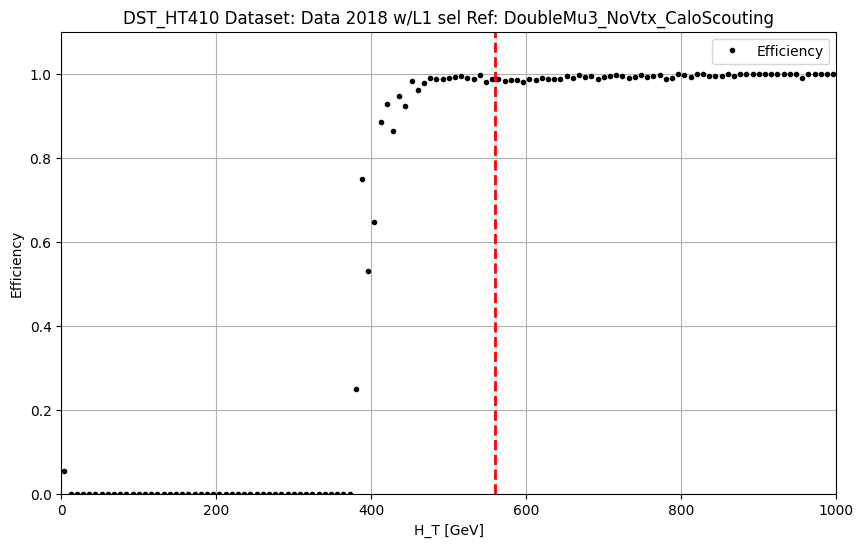

In [22]:
import ROOT
import matplotlib.pyplot as plt
import numpy as np

# Function to create and plot the efficiency histogram
def plot_efficiency_histogram(output_file_path):
    # Open the output ROOT file
    output_file = ROOT.TFile(output_file_path, "READ")

    # Retrieve the histograms
    ht_reco = output_file.Get("ht_reco")
    ht_reco_triggered = output_file.Get("ht_reco_triggered")

    # Create the efficiency histogram with 100 bins
    efficiency_hist = ROOT.TH1F("efficiency", "Efficiency;H_T [GeV];Efficiency", 125, 0, 1000)

    # Calculate efficiency
    for i in range(1, ht_reco.GetNbinsX() + 1):
        ht_reco_value = ht_reco.GetBinContent(i)
        ht_reco_triggered_value = ht_reco_triggered.GetBinContent(i)

        # Avoid division by zero
        if ht_reco_value > 0:
            efficiency = ht_reco_triggered_value / ht_reco_value
            
            # Determine the bin in the new histogram
            bin_center = ht_reco.GetBinCenter(i)
            new_bin_index = efficiency_hist.FindBin(bin_center)  # Find the corresponding bin in the new histogram
            
            # Fill the new histogram with the calculated efficiency
            efficiency_hist.SetBinContent(new_bin_index, efficiency)

    bin_centers = np.array([efficiency_hist.GetBinCenter(i) for i in range(1, efficiency_hist.GetNbinsX() + 1)])
    efficiencies = np.array([efficiency_hist.GetBinContent(i) for i in range(1, efficiency_hist.GetNbinsX() + 1)])

    # Plot using matplotlib
    plt.figure(figsize=(10, 6))
    plt.plot(bin_centers, efficiencies, marker='o', markersize=3, linestyle='None', color='black', label='Efficiency')  # Changed linestyle to 'None'
    #plt.plot(bin_centers, efficiencies, linestyle='-', color='black', label='Efficiency')  # Use a solid line
    plt.title("DST_HT410 Dataset: Data 2018 w/L1 sel Ref: DoubleMu3_NoVtx_CaloScouting")
    plt.xlabel("H_T [GeV]")
    plt.ylabel("Efficiency")
    plt.grid()
    plt.xlim(0, 1000)
    plt.axvline(x=560, color='red', linestyle='--', linewidth=2)  # Vertical line at x = 560
    plt.ylim(0, 1.1)  # Set y-limits to show efficiency properly
    plt.legend()
    plt.savefig("Data18_L1sel_eff.png")
    plt.show()


    output_file.Close()

plot_efficiency_histogram("data_18_L1sel_corr.root")



No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


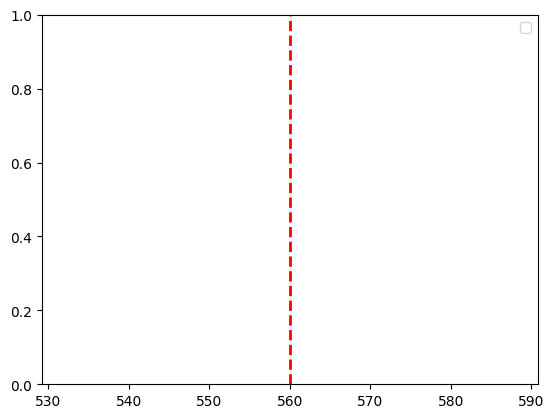

Bin 1: ht_reco_value = 8427502.0, ht_reco_DST_value = 100.0, Efficiency = 1.1865912342708433e-05
Skipping bin 2 due to zero denominator in ht_reco.
Skipping bin 3 due to zero denominator in ht_reco.
Skipping bin 4 due to zero denominator in ht_reco.
Skipping bin 5 due to zero denominator in ht_reco.
Skipping bin 6 due to zero denominator in ht_reco.
Skipping bin 7 due to zero denominator in ht_reco.
Skipping bin 8 due to zero denominator in ht_reco.
Skipping bin 9 due to zero denominator in ht_reco.
Skipping bin 10 due to zero denominator in ht_reco.
Skipping bin 11 due to zero denominator in ht_reco.
Skipping bin 12 due to zero denominator in ht_reco.
Skipping bin 13 due to zero denominator in ht_reco.
Skipping bin 14 due to zero denominator in ht_reco.
Skipping bin 15 due to zero denominator in ht_reco.
Bin 16: ht_reco_value = 5575.0, ht_reco_DST_value = 0.0, Efficiency = 0.0
Bin 17: ht_reco_value = 4407.0, ht_reco_DST_value = 0.0, Efficiency = 0.0
Bin 18: ht_reco_value = 3268.0, ht_

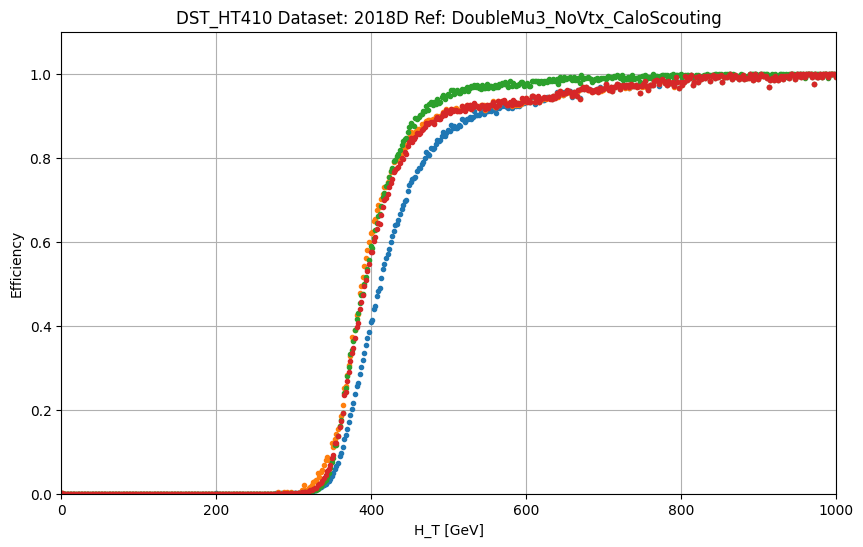

In [15]:
import ROOT
import matplotlib.pyplot as plt
import numpy as np

def plot_efficiency_histograms(output_file_path):
    # Open the output ROOT file
    output_file = ROOT.TFile(output_file_path, "READ")

    #ht_reco = output_file.Get("ht_reco")

    # Define histogram names
    histogram_names = [
        "ht_reco_DST",
        "ht_reco_DST_SingleJet",
        "ht_reco_DST_DoubleJet",
        "ht_reco_DST_SingleJet_OR_DoubleJet"
    ]

    histogram_names_den = [
        "ht_reco",
        "ht_reco_SingleJet",
        "ht_reco_DoubleJet",
        "ht_reco_SingleJet_OR_DoubleJet"
    ]
    # Prepare the plot
    plt.figure(figsize=(10, 6))
    plt.title("DST_HT410 Dataset: 2018 Ref: DoubleMu3_NoVtx_CaloScouting")
    plt.xlabel("H_T [GeV]")
    plt.ylabel("Efficiency")
    plt.grid(True)
    plt.xlim(0, 1000)
    plt.ylim(0, 1.1)

    labels = ['DST_HT410', 'DST_HT410 with Single Jet200 sel.', 'DST_HT410 with DoubleJet350 sel.', 'DST_HT410 with SingleJet200_OR_DoubleJet350 sel.']
    # for lb, hist_name in enumerate(histogram_names):
    #     hist = output_file.Get(hist_name)
    #     if hist:
    #         efficiency_hist = ROOT.TH1F(f"eff_{hist_name}", f"Efficiency;H_T [GeV];Efficiency", 500, 0, 1000)
    #         for i in range(1, ht_reco.GetNbinsX() + 1):
    #             ht_reco_value = ht_reco.GetBinContent(i)
    #             hist_value = hist.GetBinContent(i)
    #             if ht_reco_value > 0:  # Avoid division by zero
    #                 efficiency = float(hist_value) / float(ht_reco_value)
    #                 efficiency_hist.SetBinContent(i, efficiency)
    #                 print(f"Bin {i}: ht_reco_value = {ht_reco_value}, {hist_name}_value = {hist_value}, Efficiency = {efficiency}")
    #                 print(f"Debug: Histogram bin content at {i} = {efficiency_hist.GetBinContent(i)}")
    #             else:
    #                 print(f"Skipping bin {i} due to zero denominator in ht_reco.")

    #         # Convert the ROOT histogram to numpy arrays for plotting
    #         bin_centers = np.array([efficiency_hist.GetBinCenter(i) for i in range(1, efficiency_hist.GetNbinsX() + 1)])
    #         efficiencies = np.array([efficiency_hist.GetBinContent(i) for i in range(1, efficiency_hist.GetNbinsX() + 1)])
    #         print(f"Bin centers: {bin_centers}")
    #         print(f"Efficiencies: {efficiencies}")

    #         # Plot using matplotlib
    #         plt.plot(bin_centers, efficiencies, marker='o', markersize=3, linestyle='None', label=labels[lb])

    # # Add legend and vertical line
    # plt.axvline(x=560, color='red', linestyle='--', linewidth=2)
    # plt.legend()
    # plt.savefig("data18_L1sel_corr_v2.png")
    # plt.show()

    # # Close the ROOT file
    # output_file.Close()
    for idx, (num_name, den_name) in enumerate(zip(histogram_names, histogram_names_den)):
        numerator = output_file.Get(num_name)
        denominator = output_file.Get(den_name)
        if numerator and denominator:
            # Create a new histogram for efficiency
            efficiency_hist = ROOT.TH1F(f"eff_{num_name}", f"Efficiency;H_T [GeV];Efficiency", 500, 0, 1000)
            for bin_idx in range(1, denominator.GetNbinsX() + 1):
                den_value = denominator.GetBinContent(bin_idx)
                num_value = numerator.GetBinContent(bin_idx)
                if den_value > 0:  # Avoid division by zero
                    efficiency = float(num_value) / float(den_value)
                    efficiency_hist.SetBinContent(bin_idx, efficiency)
                    print(f"Bin {bin_idx}: {den_name}_value = {den_value}, {num_name}_value = {num_value}, Efficiency = {efficiency}")
                else:
                    print(f"Skipping bin {bin_idx} due to zero denominator in {den_name}.")

            # Convert the ROOT histogram to numpy arrays for plotting
            bin_centers = np.array([efficiency_hist.GetBinCenter(bin_idx) for bin_idx in range(1, efficiency_hist.GetNbinsX() + 1)])
            efficiencies = np.array([efficiency_hist.GetBinContent(bin_idx) for bin_idx in range(1, efficiency_hist.GetNbinsX() + 1)])
            print(f"Bin centers: {bin_centers}")
            print(f"Efficiencies: {efficiencies}")

            # Plot using matplotlib
            plt.plot(bin_centers, efficiencies, marker='o', markersize=3, linestyle='None', label=labels[idx])
            


plt.axvline(x=560, color='red', linestyle='--', linewidth=2)
plt.legend()
plt.savefig("data18_L1sel_corr_v2.png")
plt.show()

# Close the ROOT file
#output_file.Close()

# Call the function with the path to your ROOT file
plot_efficiency_histograms("data_18_L1sel_corr_v2.root")


Processing: ht_reco_DST / ht_reco
Bin 1: Numerator (ht_reco_DST) = 100.0, Denominator (ht_reco) = 8427502.0
Bin 2: Numerator (ht_reco_DST) = 0.0, Denominator (ht_reco) = 0.0
Skipping bin 2 due to zero denominator in ht_reco.
Bin 3: Numerator (ht_reco_DST) = 0.0, Denominator (ht_reco) = 0.0
Skipping bin 3 due to zero denominator in ht_reco.
Bin 4: Numerator (ht_reco_DST) = 0.0, Denominator (ht_reco) = 0.0
Skipping bin 4 due to zero denominator in ht_reco.
Bin 5: Numerator (ht_reco_DST) = 0.0, Denominator (ht_reco) = 0.0
Skipping bin 5 due to zero denominator in ht_reco.
Bin 6: Numerator (ht_reco_DST) = 0.0, Denominator (ht_reco) = 0.0
Skipping bin 6 due to zero denominator in ht_reco.
Bin 7: Numerator (ht_reco_DST) = 0.0, Denominator (ht_reco) = 0.0
Skipping bin 7 due to zero denominator in ht_reco.
Bin 8: Numerator (ht_reco_DST) = 0.0, Denominator (ht_reco) = 0.0
Skipping bin 8 due to zero denominator in ht_reco.
Bin 9: Numerator (ht_reco_DST) = 0.0, Denominator (ht_reco) = 0.0
Skippi

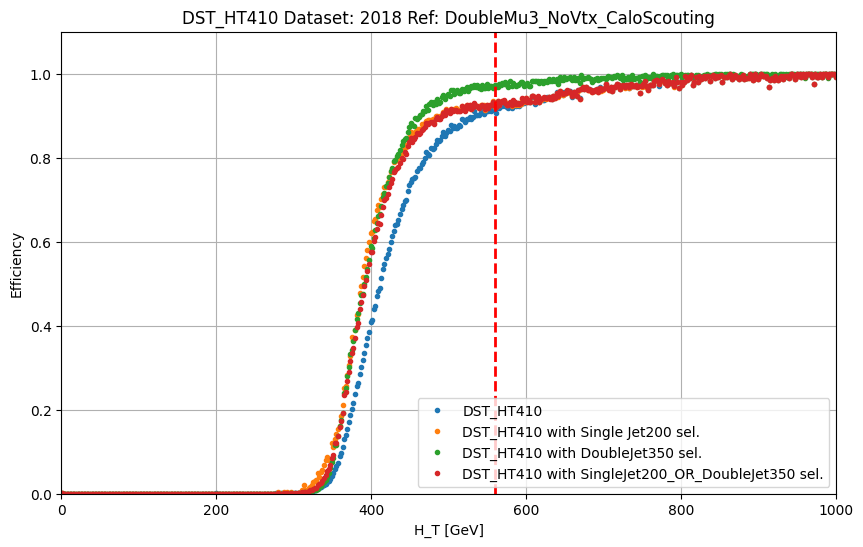

In [2]:
import ROOT
import matplotlib.pyplot as plt
import numpy as np

def plot_efficiency_histograms(output_file_path):
    # Open the output ROOT file
    output_file = ROOT.TFile(output_file_path, "READ")

    # Define histogram names
    histogram_names = [
        "ht_reco_DST",
        "ht_reco_DST_SingleJet",
        "ht_reco_DST_DoubleJet",
        "ht_reco_DST_SingleJet_OR_DoubleJet"
    ]

    histogram_names_den = [
        "ht_reco",
        "ht_reco_SingleJet",
        "ht_reco_DoubleJet",
        "ht_reco_SingleJet_OR_DoubleJet"
    ]

    labels = ['DST_HT410', 'DST_HT410 with Single Jet200 sel.', 'DST_HT410 with DoubleJet350 sel.', 'DST_HT410 with SingleJet200_OR_DoubleJet350 sel.']

    # Prepare the plot
    plt.figure(figsize=(10, 6))
    plt.title("DST_HT410 Dataset: 2018 Ref: DoubleMu3_NoVtx_CaloScouting")
    plt.xlabel("H_T [GeV]")
    plt.ylabel("Efficiency")
    plt.grid(True)
    plt.xlim(0, 1000)
    plt.ylim(0, 1.1)

    for idx, (num_name, den_name) in enumerate(zip(histogram_names, histogram_names_den)):
        numerator = output_file.Get(num_name)
        denominator = output_file.Get(den_name)
        if numerator and denominator:
            print(f"\nProcessing: {num_name} / {den_name}")
            efficiency_hist = ROOT.TH1F(f"eff_{num_name}", "Efficiency;H_T [GeV];Efficiency", 500, 0, 1000)
            for bin_idx in range(1, denominator.GetNbinsX() + 1):
                den_value = denominator.GetBinContent(bin_idx)
                num_value = numerator.GetBinContent(bin_idx)
                print(f"Bin {bin_idx}: Numerator ({num_name}) = {num_value}, Denominator ({den_name}) = {den_value}")
                if den_value > 0:
                    efficiency = float(num_value) / float(den_value)
                    efficiency_hist.SetBinContent(bin_idx, efficiency)
                else:
                    print(f"Skipping bin {bin_idx} due to zero denominator in {den_name}.")

            bin_centers = np.array([efficiency_hist.GetBinCenter(bin_idx) for bin_idx in range(1, efficiency_hist.GetNbinsX() + 1)])
            efficiencies = np.array([efficiency_hist.GetBinContent(bin_idx) for bin_idx in range(1, efficiency_hist.GetNbinsX() + 1)])

            plt.plot(bin_centers, efficiencies, marker='o', markersize=3, linestyle='None', label=labels[idx])

    plt.axvline(x=560, color='red', linestyle='--', linewidth=2)
    plt.legend()
    plt.savefig("data18_L1sel_corr_v2.png")
    plt.show()



# Call the function with the path to your ROOT file
plot_efficiency_histograms("data_18_L1sel_corr_v2.root")

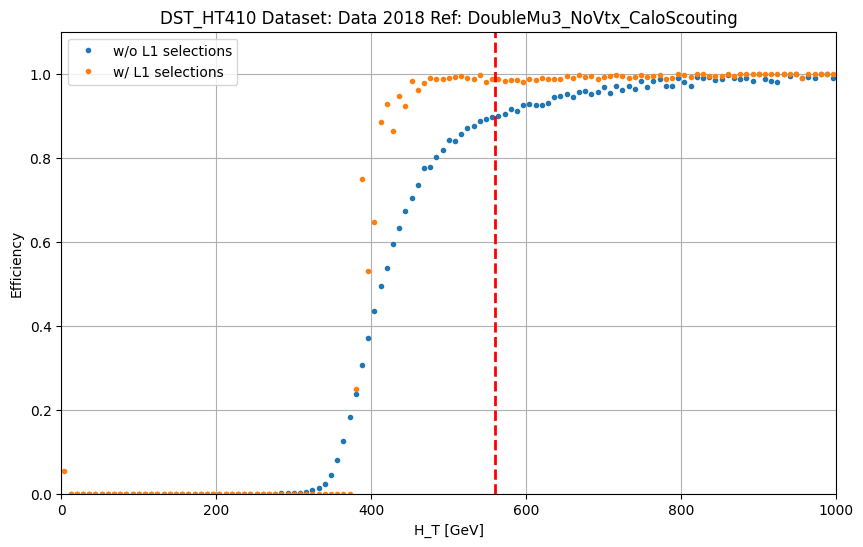

In [24]:
import ROOT
import matplotlib.pyplot as plt
import numpy as np


def plot_efficiency_histogram(file_paths, labels, output_image):
    plt.figure(figsize=(10, 6))
    
    for file_path, label in zip(file_paths, labels):
        # Open the output ROOT file
        output_file = ROOT.TFile(file_path, "READ")

        # Retrieve the histograms
        ht_reco = output_file.Get("ht_reco")
        ht_reco_triggered = output_file.Get("ht_reco_triggered")

        # Create the efficiency histogram with 100 bins
        efficiency_hist = ROOT.TH1F("efficiency", "Efficiency;H_T [GeV];Efficiency", 125, 0, 1000)
        # Calculate efficiency
        for i in range(1, ht_reco.GetNbinsX() + 1):
            ht_reco_value = ht_reco.GetBinContent(i)
            ht_reco_triggered_value = ht_reco_triggered.GetBinContent(i)

            # Avoid division by zero
            if ht_reco_value > 0:
                efficiency = ht_reco_triggered_value / ht_reco_value
                
                # Determine the bin in the new histogram
                bin_center = ht_reco.GetBinCenter(i)
                new_bin_index = efficiency_hist.FindBin(bin_center)  # Find the corresponding bin in the new histogram
                
                # Fill the new histogram with the calculated efficiency
                efficiency_hist.SetBinContent(new_bin_index, efficiency)

        # Optionally, convert the ROOT histogram to a numpy array for use with matplotlib
        bin_centers = np.array([efficiency_hist.GetBinCenter(i) for i in range(1, efficiency_hist.GetNbinsX() + 1)])
        efficiencies = np.array([efficiency_hist.GetBinContent(i) for i in range(1, efficiency_hist.GetNbinsX() + 1)])

        # Plot using matplotlib
        plt.plot(bin_centers, efficiencies, marker='o', markersize=3, linestyle='None', label=label)

        output_file.Close()

    plt.title("DST_HT410 Dataset: Data 2018 Ref: DoubleMu3_NoVtx_CaloScouting")
    plt.xlabel("H_T [GeV]")
    plt.ylabel("Efficiency")
    plt.grid()
    plt.xlim(0, 1000)
    plt.axvline(x=560, color='red', linestyle='--', linewidth=2)  # Vertical line at x = 560
    plt.ylim(0, 1.1)  # Set y-limits to show efficiency properly
    plt.legend()
    plt.savefig(output_image)
    plt.show()

# List of file paths and corresponding labels
file_paths = [
    "data18.root",
    "data_18_L1sel.root"
    
]
labels = [
    "w/o L1 selections",
    "w/ L1 selections"
]

# Call the function to plot histograms
plot_efficiency_histogram(file_paths, labels, "signal_eff.png")

In [31]:
# load file names
year = 2018
outDir = '/home/submit/{}/public_html/{}/'.format(os.environ['USER'], 'SUEP/analysis/trigSF/')


#if not os.path.isdir(outDir): os.mkdir(outDir)

#with open('/home/submit/lavezzo/luca_json/'+str(year)+'_new.json', 'r') as f: samples = json.load(f)
#with open('filelist/2017.json', 'r') as f: samples = json.load(f)

sample_input_redirector = 'root://xrootd.cmsaf.mit.edu/'
data2018 = '../../filelist/Scout/list_2018_scout_data_test.txt'
MC2018 = '../../filelist/Scout/list_2018_scout_MC_test.txt'
data18_PFComm = '../../filelist/Scout/list_2018_scout_PFComm.txt'

sample_paths = []
sample_names = []

with open(data18_PFComm, 'r') as file:
    for iter, line in enumerate(file):
        if iter >= 100:  # Exit after 100 iterations
            break
        comm = subprocess.Popen(
            ["xrdfs", sample_input_redirector, "ls", line.strip()],
            stdout=subprocess.PIPE,
        )
        output = comm.communicate()[0].decode("utf-8")
        sample_path = line.strip()
        sample_name = '_'.join(sample_path.split('/')[-1].split('_')[0:2])
        sample_paths.append([sample_input_redirector + f for f in output.split("\n") if ".root" in f])
        sample_names.append(sample_name)
        
for s in sample_paths[0]:
    print('xrdcp ',s, ' .')
print(sample_paths)

# data_paths = []
# data_names = []

#samples = dict(zip(sample_names, sample_paths))

# datalist = []
# nBad = 0
# for k in list(samples.keys()):

#     if 'data' in k.lower(): 
#         datalist += samples.pop(k)

# if len(datalist) >0: samples['Data'] = datalist

#print(samples.keys())

xrdcp  root://xrootd.cmsaf.mit.edu//store/user/paus/nanosc/E08//ScoutingPFCommissioning+Run2018A-v1+RAW/00213724-234E-E811-8A84-FA163E1524DA.root  .
xrdcp  root://xrootd.cmsaf.mit.edu//store/user/paus/nanosc/E08//ScoutingPFCommissioning+Run2018A-v1+RAW/00428521-FC53-E811-9246-FA163EB54123.root  .
xrdcp  root://xrootd.cmsaf.mit.edu//store/user/paus/nanosc/E08//ScoutingPFCommissioning+Run2018A-v1+RAW/008CF390-FC49-E811-83F0-FA163E014A3A.root  .
xrdcp  root://xrootd.cmsaf.mit.edu//store/user/paus/nanosc/E08//ScoutingPFCommissioning+Run2018A-v1+RAW/00B52222-3F64-E811-961B-FA163E166FD3.root  .
xrdcp  root://xrootd.cmsaf.mit.edu//store/user/paus/nanosc/E08//ScoutingPFCommissioning+Run2018A-v1+RAW/0214FD37-F34A-E811-9FAC-FA163E8A4C1F.root  .
xrdcp  root://xrootd.cmsaf.mit.edu//store/user/paus/nanosc/E08//ScoutingPFCommissioning+Run2018A-v1+RAW/0233F80B-D764-E811-AD51-FA163E3BB17B.root  .
xrdcp  root://xrootd.cmsaf.mit.edu//store/user/paus/nanosc/E08//ScoutingPFCommissioning+Run2018A-v1+RAW/02

In [19]:
#sample_names= [name.replace("_______","") for name in sample_names]
sample_names
samples = dict(zip(sample_names, sample_paths))
samples.keys()

dict_keys(['QCD_HT1000to1500'])

In [20]:
# produce a skimmed dict with 10% of files of original samples
fraction = 0.01

skimmedSamples = {}
for k in list(samples.keys())[:1]:

    nFiles = round(len(samples[k])*fraction)
    toAdd = random.sample(samples[k], nFiles)
    skimmedSamples[k] = toAdd

print(skimmedSamples)

{'QCD_HT1000to1500': ['root://xrootd.cmsaf.mit.edu//store/user/paus/nanosc/E07/QCD_HT1000to1500_TuneCP5_13TeV-madgraphMLM-pythia8+RunIISummer20UL18RECO-106X_upgrade2018_realistic_v11_L1v1-v2+AODSIM//65C96F52-3361-B34F-85B7-627889414C3A.root', 'root://xrootd.cmsaf.mit.edu//store/user/paus/nanosc/E07/QCD_HT1000to1500_TuneCP5_13TeV-madgraphMLM-pythia8+RunIISummer20UL18RECO-106X_upgrade2018_realistic_v11_L1v1-v2+AODSIM//594319AC-90AD-EA4E-A200-C4AEED9704A9.root', 'root://xrootd.cmsaf.mit.edu//store/user/paus/nanosc/E07/QCD_HT1000to1500_TuneCP5_13TeV-madgraphMLM-pythia8+RunIISummer20UL18RECO-106X_upgrade2018_realistic_v11_L1v1-v2+AODSIM//296457F9-535F-B041-9F6A-911A50C181C9.root', 'root://xrootd.cmsaf.mit.edu//store/user/paus/nanosc/E07/QCD_HT1000to1500_TuneCP5_13TeV-madgraphMLM-pythia8+RunIISummer20UL18RECO-106X_upgrade2018_realistic_v11_L1v1-v2+AODSIM//D42F161A-5CA5-2943-8EC6-162528513CD3.root', 'root://xrootd.cmsaf.mit.edu//store/user/paus/nanosc/E07/QCD_HT1000to1500_TuneCP5_13TeV-madgra

In [21]:
# cross section
xsections = {}
for sample in list(samples.keys()):
    xsection = 1.0
    if 'QCD' in sample:
        with open('../../data/xsections_{}.json'.format(year)) as file:
            MC_xsecs = json.load(file)

            if year == 2016:
                if 'preVFP' in sample:
                    sample_name = 'QCD_'+sample[3:-6]+'_TuneCP5_PSWeights_13TeV-madgraphMLM-pythia8+RunIISummer20UL16MiniAODAPVv2-106X_mcRun2_asymptotic_preVFP_v11-v1+MINIAODSIM'
                else:
                    sample_name = "QCD_"+sample[3:]+"_TuneCP5_PSWeights_13TeV-madgraphMLM-pythia8+RunIISummer20UL16MiniAODv2-106X_mcRun2_asymptotic_v17-v1+MINIAODSIM"
            elif year == 2017:
                sample_name = 'QCD_'+sample[3:]+"_TuneCP5_PSWeights_13TeV-madgraph-pythia8+RunIISummer20UL17MiniAODv2-106X_mc2017_realistic_v9-v1+MINIAODSIM"
            elif year == 2018:
                if 'HT700' in sample:
                    sample_name = 'QCD_'+sample[4:]+"_TuneCP5_PSWeights_13TeV-madgraph-pythia8+RunIISummer20UL18MiniAODv2-106X_upgrade2018_realistic_v16_L1v1-v2+MINIAODSIM"
                else:
                    sample_name = 'QCD_'+sample[4:]+"_TuneCP5_PSWeights_13TeV-madgraph-pythia8+RunIISummer20UL18MiniAODv2-106X_upgrade2018_realistic_v16_L1v1-v1+MINIAODSIM"

            try:
                xsection *= MC_xsecs[sample_name]["xsec"]
                xsection *= MC_xsecs[sample_name]["kr"]
                xsection *= MC_xsecs[sample_name]["br"]
            except:
                print("WARNING: I did not find the xsection for that MC sample. Check the dataset name and the relevant yaml file")
                print(sample_name)

        xsections.update({sample:xsection})
    else:
        xsections.update({sample:xsection})

In [22]:
xsections

{'QCD_HT1000to1500': 1127.0}

## Dask Slurm Cluster
WARNING: this is a bit finnicky. Below there is a more stable "Futures Executor" which runs the jobs to the local machine instead of using a Dask Cluster on Slurm.

The next section forms the Slurm Cluster. You can set up various parameters of the cluster here.

In [28]:
def check_port(port):
    import socket
    sock = socket.socket(socket.AF_INET, socket.SOCK_STREAM)
    try:
        sock.bind(("0.0.0.0", port))
        available = True
    except:
        available = False
    sock.close()
    return available

slurm_env = [
    'export XRD_RUNFORKHANDLER=1',
    'export XRD_STREAMTIMEOUT=100',
     f'source {os.environ["HOME"]}/.bashrc',
     f'conda activate SUEP',
     f'export X509_USER_PROXY={os.environ["HOME"]}/x509up_u210253',
     'echo "----- Found Proxy in: $X509_USER_PROXY"',
     'voms-proxy-info',
     f'sleep $[ ( $RANDOM % 100 )  + 1 ]s'
]

extra_args=[
     "--output=logs/dask_job_output_%j.out",
     "--error=logs/dask_job_output_%j.err",
     "--partition=submit",
     "--clusters=submit",
]

n_port       = 6820
w_port       = 9765
cores        = 1
processes    = 100
memory       = "5 GB"
chunksize    = 10000000
maxchunks    = None

In [29]:
while not check_port(n_port):
    n_port += 1
    time.sleep(5)

import socket
cluster = SLURMCluster(
        queue='all',
        project="SUEP_Slurm",
        cores=10,
        processes=processes,
        memory=memory,
        walltime='00:30:00',
        scheduler_options={
              'port': n_port,
              'dashboard_address': 8002,
              'host': socket.gethostname()
        },
        job_extra=extra_args,
        env_extra=slurm_env,
)

/work/submit/akanugan/miniforge3/envs/SUEP/lib/python3.9/site-packages/dask_jobqueue/core.py:255: FutureWarning: job_extra has been renamed to job_extra_directives. You are still using it (even if only set to []; please also check config files). If you did not set job_extra_directives yet, job_extra will be respected for now, but it will be removed in a future release. If you already set job_extra_directives, job_extra is ignored and you can remove it.
  warnings.warn(warn, FutureWarning)
/work/submit/akanugan/miniforge3/envs/SUEP/lib/python3.9/site-packages/dask_jobqueue/core.py:274: FutureWarning: env_extra has been renamed to job_script_prologue. You are still using it (even if only set to []; please also check config files). If you did not set job_script_prologue yet, env_extra will be respected for now, but it will be removed in a future release. If you already set job_script_prologue, env_extra is ignored and you can remove it.
  warnings.warn(warn, FutureWarning)
/work/submit/ak

In [30]:
cluster.adapt(minimum=1, maximum=10)
client = Client(cluster)
print(client)

<Client: 'tcp://18.4.134.161:6820' processes=0 threads=0, memory=0 B>


/work/submit/akanugan/miniforge3/envs/SUEP/lib/python3.9/site-packages/dask_jobqueue/core.py:255: FutureWarning: job_extra has been renamed to job_extra_directives. You are still using it (even if only set to []; please also check config files). If you did not set job_extra_directives yet, job_extra will be respected for now, but it will be removed in a future release. If you already set job_extra_directives, job_extra is ignored and you can remove it.
  warnings.warn(warn, FutureWarning)
/work/submit/akanugan/miniforge3/envs/SUEP/lib/python3.9/site-packages/dask_jobqueue/core.py:274: FutureWarning: env_extra has been renamed to job_script_prologue. You are still using it (even if only set to []; please also check config files). If you did not set job_script_prologue yet, env_extra will be respected for now, but it will be removed in a future release. If you already set job_script_prologue, env_extra is ignored and you can remove it.
  warnings.warn(warn, FutureWarning)
/work/submit/ak

In [31]:
processor_instance = Simple_Process(isMC=1, era=year, sample='test')
with performance_report(filename="dask-report.html"):

    runner = processor.Runner(
        executor = processor.dask_executor(client = client, retries= 4),
        schema = processor.NanoAODSchema,
        xrootdtimeout = 60,
        chunksize=10000,
        skipbadfiles=True
    )

    output = runner.automatic_retries(retries=3, skipbadfiles=True, func=runner.run,
        fileset=skimmedSamples,
        treename="mmtree",
        processor_instance=processor_instance,
    )

    now = datetime.datetime.now()
    coffea.util.save(output, "unscaled-{}.coffea".format(now.strftime("%H:%M:%S")))

[                                        ] | 0% Completed | 14.1s

KeyboardInterrupt: 

In [32]:
client.cancel(cluster)

## Futures Executor

In [36]:
for path in skimmedSamples['QCD_HT1000to1500']:
    if os.path.exists(path) and os.path.isfile(path):  # Check if it's a file
        print(f"File exists: {path}")
    else:
        print(f"File does not exist or is a directory: {path}")

File does not exist or is a directory: root://xrootd.cmsaf.mit.edu//store/user/paus/nanosc/E07/QCD_HT1000to1500_TuneCP5_13TeV-madgraphMLM-pythia8+RunIISummer20UL18RECO-106X_upgrade2018_realistic_v11_L1v1-v2+AODSIM//65C96F52-3361-B34F-85B7-627889414C3A.root
File does not exist or is a directory: root://xrootd.cmsaf.mit.edu//store/user/paus/nanosc/E07/QCD_HT1000to1500_TuneCP5_13TeV-madgraphMLM-pythia8+RunIISummer20UL18RECO-106X_upgrade2018_realistic_v11_L1v1-v2+AODSIM//594319AC-90AD-EA4E-A200-C4AEED9704A9.root
File does not exist or is a directory: root://xrootd.cmsaf.mit.edu//store/user/paus/nanosc/E07/QCD_HT1000to1500_TuneCP5_13TeV-madgraphMLM-pythia8+RunIISummer20UL18RECO-106X_upgrade2018_realistic_v11_L1v1-v2+AODSIM//296457F9-535F-B041-9F6A-911A50C181C9.root
File does not exist or is a directory: root://xrootd.cmsaf.mit.edu//store/user/paus/nanosc/E07/QCD_HT1000to1500_TuneCP5_13TeV-madgraphMLM-pythia8+RunIISummer20UL18RECO-106X_upgrade2018_realistic_v11_L1v1-v2+AODSIM//D42F161A-5CA5-

In [34]:
import os
from coffea.processor import run_uproot_job

# Define the processor instance
processor_instance = Simple_Process(isMC=1, era=year, sample='test')

# Check if skimmedSamples contains valid files
valid_files = {k: v for k, v in skimmedSamples.items() if all(os.path.exists(f) for f in v)}

if valid_files:
    # Run the processor using the Coffea framework
    output = run_uproot_job(
        fileset=valid_files,
        treename="mmtree",
        processor_instance=processor_instance,
        executor=processor.futures_executor,
        executor_args={'workers': 20},
        chunksize=10000,
        maxchunks=None,
        skipbadfiles=True
    )

    # Save the output
    now = datetime.datetime.now()
    coffea.util.save(output, "unscaled-{}.coffea".format(now.strftime("%H:%M:%S")))
else:
    print("No valid files found in skimmedSamples.")

No valid files found in skimmedSamples.


In [35]:
processor_instance = Simple_Process(isMC=1, era=year, sample='test')

runner = processor.Runner(
        executor = processor.futures_executor(workers = 20),
        #executor = processor.IterativeExecutor(workers=20),
        schema = processor.NanoAODSchema,
        xrootdtimeout = 120,
        chunksize = 10000000,
        skipbadfiles=True
    )

output = runner.automatic_retries(retries=3, skipbadfiles=True, func=runner.run,
    fileset=skimmedSamples,
    treename="mmtree",
    processor_instance=processor_instance,
)

now = datetime.datetime.now()
coffea.util.save(output, "unscaled-{}.coffea".format(now.strftime("%H:%M:%S")))

print("Exceptions:", output['exception'])

Output()

/work/submit/akanugan/miniforge3/envs/SUEP/lib/python3.9/site-packages/dask_jobqueue/core.py:255: FutureWarning: 
job_extra has been renamed to job_extra_directives. You are still using it (even if only set to []; please also 
check config files). If you did not set job_extra_directives yet, job_extra will be respected for now, but it will 
be removed in a future release. If you already set job_extra_directives, job_extra is ignored and you can remove 
it.
  warnings.warn(warn, FutureWarning)
  Preprocessing   0% ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 0/21 [ 0:00:00 < -:--:-- | ?   file/s ]
Merging (local)   0% ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━  0/0 [ 0:00:00 < -:--:-- | ? merges/s ]

/work/submit/akanugan/miniforge3/envs/SUEP/lib/python3.9/site-packages/dask_jobqueue/core.py:274: FutureWarning: 
env_extra has been renamed to job_script_prologue. You are still using it (even if only set to []; please also 
check config files). If you did not set job_script_prologue yet, env_extra will be respected for now, but it will 
be removed in a future release. If you already set job_script_prologue, env_extra is ignored and you can remove it.
  warnings.warn(warn, FutureWarning)
  Preprocessing   0% ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 0/21 [ 0:00:00 < -:--:-- | ?   file/s ]
Merging (local)   0% ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━  0/0 [ 0:00:00 < -:--:-- | ? merges/s ]

/work/submit/akanugan/miniforge3/envs/SUEP/lib/python3.9/site-packages/dask_jobqueue/slurm.py:49: FutureWarning: 
project has been renamed to account as this kwarg was used wit -A option. You are still using it (please also check
config files). If you did not set account yet, project will be respected for now, but it will be removed in a 
future release. If you already set account, project is ignored and you can remove it.
  warnings.warn(warn, FutureWarning)
  Preprocessing   0% ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 0/21 [ 0:00:00 < -:--:-- | ?   file/s ]
Merging (local)   0% ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━  0/0 [ 0:00:00 < -:--:-- | ? merges/s ]

concurrent.futures.process._RemoteTraceback: 
"""
Traceback (most recent call last):
  File "/work/submit/akanugan/miniforge3/envs/SUEP/lib/python3.9/concurrent/futures/process.py", line 246, in _process_worker
    r = call_item.fn(*call_item.args, **call_item.kwargs)
  File "/work/submit/akanugan/miniforge3/envs/SUEP/lib/python3.9/site-packages/coffea/processor/executor.py", line 1353, in automatic_retries
    raise e
  File "/work/submit/akanugan/miniforge3/envs/SUEP/lib/python3.9/site-packages/coffea/processor/executor.py", line 1337, in automatic_retries
    return func(*args, **kwargs)
  File "/work/submit/akanugan/miniforge3/envs/SUEP/lib/python3.9/site-packages/coffea/processor/executor.py", line 1412, in metadata_fetcher
    metadata.update({"numentries": tree.num_entries, "uuid": file.file.fUUID})
AttributeError: 'ReadOnlyDirectory' object has no attribute 'num_entries'
"""

The above exception was the direct cause of the following exception:

Traceback (most recent call last)

Output()

/work/submit/akanugan/miniforge3/envs/SUEP/lib/python3.9/site-packages/dask_jobqueue/core.py:255: FutureWarning: 
job_extra has been renamed to job_extra_directives. You are still using it (even if only set to []; please also 
check config files). If you did not set job_extra_directives yet, job_extra will be respected for now, but it will 
be removed in a future release. If you already set job_extra_directives, job_extra is ignored and you can remove 
it.
  warnings.warn(warn, FutureWarning)
  Preprocessing   0% ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 0/21 [ 0:00:00 < -:--:-- | ?   file/s ]
Merging (local)   0% ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━  0/0 [ 0:00:00 < -:--:-- | ? merges/s ]

/work/submit/akanugan/miniforge3/envs/SUEP/lib/python3.9/site-packages/dask_jobqueue/core.py:274: FutureWarning: 
env_extra has been renamed to job_script_prologue. You are still using it (even if only set to []; please also 
check config files). If you did not set job_script_prologue yet, env_extra will be respected for now, but it will 
be removed in a future release. If you already set job_script_prologue, env_extra is ignored and you can remove it.
  warnings.warn(warn, FutureWarning)
  Preprocessing   0% ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 0/21 [ 0:00:00 < -:--:-- | ?   file/s ]
Merging (local)   0% ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━  0/0 [ 0:00:00 < -:--:-- | ? merges/s ]

/work/submit/akanugan/miniforge3/envs/SUEP/lib/python3.9/site-packages/dask_jobqueue/slurm.py:49: FutureWarning: 
project has been renamed to account as this kwarg was used wit -A option. You are still using it (please also check
config files). If you did not set account yet, project will be respected for now, but it will be removed in a 
future release. If you already set account, project is ignored and you can remove it.
  warnings.warn(warn, FutureWarning)
  Preprocessing   0% ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 0/21 [ 0:00:00 < -:--:-- | ?   file/s ]
Merging (local)   0% ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━  0/0 [ 0:00:00 < -:--:-- | ? merges/s ]

concurrent.futures.process._RemoteTraceback: 
"""
Traceback (most recent call last):
  File "/work/submit/akanugan/miniforge3/envs/SUEP/lib/python3.9/concurrent/futures/process.py", line 246, in _process_worker
    r = call_item.fn(*call_item.args, **call_item.kwargs)
  File "/work/submit/akanugan/miniforge3/envs/SUEP/lib/python3.9/site-packages/coffea/processor/executor.py", line 1353, in automatic_retries
    raise e
  File "/work/submit/akanugan/miniforge3/envs/SUEP/lib/python3.9/site-packages/coffea/processor/executor.py", line 1337, in automatic_retries
    return func(*args, **kwargs)
  File "/work/submit/akanugan/miniforge3/envs/SUEP/lib/python3.9/site-packages/coffea/processor/executor.py", line 1412, in metadata_fetcher
    metadata.update({"numentries": tree.num_entries, "uuid": file.file.fUUID})
AttributeError: 'ReadOnlyDirectory' object has no attribute 'num_entries'
"""

The above exception was the direct cause of the following exception:

Traceback (most recent call last)

Output()

/work/submit/akanugan/miniforge3/envs/SUEP/lib/python3.9/site-packages/dask_jobqueue/core.py:255: FutureWarning: 
job_extra has been renamed to job_extra_directives. You are still using it (even if only set to []; please also 
check config files). If you did not set job_extra_directives yet, job_extra will be respected for now, but it will 
be removed in a future release. If you already set job_extra_directives, job_extra is ignored and you can remove 
it.
  warnings.warn(warn, FutureWarning)
  Preprocessing   0% ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 0/21 [ 0:00:00 < -:--:-- | ?   file/s ]
Merging (local)   0% ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━  0/0 [ 0:00:00 < -:--:-- | ? merges/s ]

/work/submit/akanugan/miniforge3/envs/SUEP/lib/python3.9/site-packages/dask_jobqueue/core.py:274: FutureWarning: 
env_extra has been renamed to job_script_prologue. You are still using it (even if only set to []; please also 
check config files). If you did not set job_script_prologue yet, env_extra will be respected for now, but it will 
be removed in a future release. If you already set job_script_prologue, env_extra is ignored and you can remove it.
  warnings.warn(warn, FutureWarning)
  Preprocessing   0% ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 0/21 [ 0:00:00 < -:--:-- | ?   file/s ]
Merging (local)   0% ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━  0/0 [ 0:00:00 < -:--:-- | ? merges/s ]

/work/submit/akanugan/miniforge3/envs/SUEP/lib/python3.9/site-packages/dask_jobqueue/slurm.py:49: FutureWarning: 
project has been renamed to account as this kwarg was used wit -A option. You are still using it (please also check
config files). If you did not set account yet, project will be respected for now, but it will be removed in a 
future release. If you already set account, project is ignored and you can remove it.
  warnings.warn(warn, FutureWarning)
  Preprocessing   0% ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 0/21 [ 0:00:00 < -:--:-- | ?   file/s ]
Merging (local)   0% ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━  0/0 [ 0:00:00 < -:--:-- | ? merges/s ]

concurrent.futures.process._RemoteTraceback: 
"""
Traceback (most recent call last):
  File "/work/submit/akanugan/miniforge3/envs/SUEP/lib/python3.9/concurrent/futures/process.py", line 246, in _process_worker
    r = call_item.fn(*call_item.args, **call_item.kwargs)
  File "/work/submit/akanugan/miniforge3/envs/SUEP/lib/python3.9/site-packages/coffea/processor/executor.py", line 1353, in automatic_retries
    raise e
  File "/work/submit/akanugan/miniforge3/envs/SUEP/lib/python3.9/site-packages/coffea/processor/executor.py", line 1337, in automatic_retries
    return func(*args, **kwargs)
  File "/work/submit/akanugan/miniforge3/envs/SUEP/lib/python3.9/site-packages/coffea/processor/executor.py", line 1412, in metadata_fetcher
    metadata.update({"numentries": tree.num_entries, "uuid": file.file.fUUID})
AttributeError: 'ReadOnlyDirectory' object has no attribute 'num_entries'
"""

The above exception was the direct cause of the following exception:

Traceback (most recent call last)

Output()

concurrent.futures.process._RemoteTraceback: 
"""
Traceback (most recent call last):
  File "/work/submit/akanugan/miniforge3/envs/SUEP/lib/python3.9/concurrent/futures/process.py", line 246, in _process_worker
    r = call_item.fn(*call_item.args, **call_item.kwargs)
  File "/work/submit/akanugan/miniforge3/envs/SUEP/lib/python3.9/site-packages/coffea/processor/executor.py", line 1353, in automatic_retries
    raise e
  File "/work/submit/akanugan/miniforge3/envs/SUEP/lib/python3.9/site-packages/coffea/processor/executor.py", line 1337, in automatic_retries
    return func(*args, **kwargs)
  File "/work/submit/akanugan/miniforge3/envs/SUEP/lib/python3.9/site-packages/coffea/processor/executor.py", line 1412, in metadata_fetcher
    metadata.update({"numentries": tree.num_entries, "uuid": file.file.fUUID})
AttributeError: 'ReadOnlyDirectory' object has no attribute 'num_entries'
"""

The above exception was the direct cause of the following exception:

Traceback (most recent call last)

AttributeError: 'ReadOnlyDirectory' object has no attribute 'num_entries'

## Analysis

In [22]:
# just in case this isn't working as expected
#coffea.util.save(output, "unscaled_output.coffea")

outputs = coffea.util.load("unscaled-21:18:19.coffea")
output = outputs['out']

# calculate normalization
scales = {} 
for dataset in output["sumw"]:
    lumi = 1.0 # don't need to normalize to lumi for this
    if "muon"  in dataset.lower() or 'data' in dataset.lower():
        scale = 1.0
    else:
        xsec = xsections[dataset]
        scale = lumi * xsec / output["sumw"][dataset]
    scales.update({dataset: scale})


# apply normalization to all histograms
for key in list(output.keys()):
    if key.lower() == 'sumw': continue
    print(key)
    output[key].scale(scales, axis='dataset')

coffea.util.save(output, "10percent_MC_2016.coffea")

ht_reco
ht_reco_triggered
nmuons
muon_pt
muon_pt_triggered
MET


### We can make some plots here too! But most of the analysis is in Dask_analysis.ipynb

In [30]:
output = coffea.util.load("10percent_MC_2016.coffea")
output_mu = coffea.util.load("10percent_Muon_2016.coffea")

/work/submit/lavezzo/miniforge3/envs/SUEP/lib/python3.9/site-packages/coffea/hist/plot.py:333: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  ax.set_ylim(0, None)


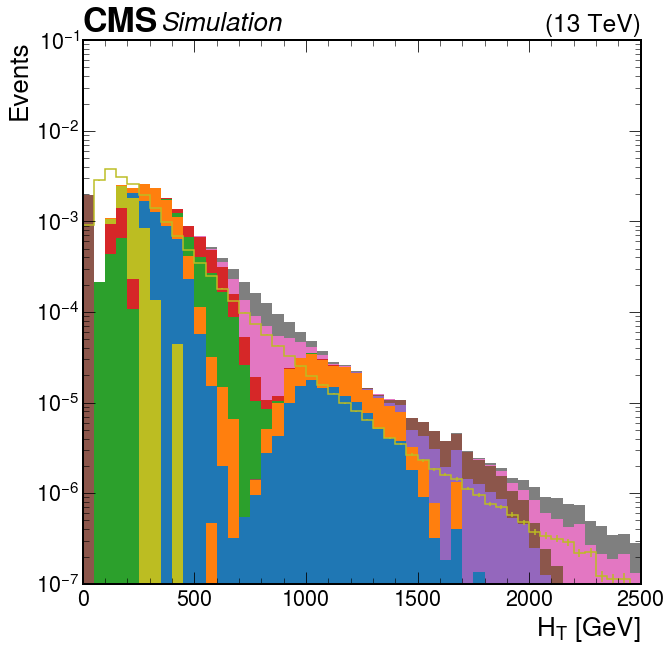

In [31]:
from coffea.hist import plot
import matplotlib.pyplot as plt
import mplhep as hep

fig = plt.figure()
ax = fig.subplots()

#hep.cms.label(data=False, year='2018')
hep.style.use("ROOT")
# {"ALICE" | "ATLAS" | "CMS" | "LHCb1" | "LHCb2"}
hep.cms.label(data=False)

_ = ax.set_yscale('log')
coffea.hist.plot.plot1d(output['ht_reco']['QCDHT*'], ax=ax, clear=False, stack=True, density=True)
coffea.hist.plot.plot1d(output_mu['ht_reco']['Data'], ax=ax, clear=False, stack=False, density=True)

_ = ax.set_xlim(0, 2500)
_ = ax.set_ylim(1e-7, 1e-1)
ax.get_legend().remove()

plt.savefig(outDir + 'ht_reco_{}.pdf'.format(year))

/work/submit/lavezzo/miniforge3/envs/SUEP/lib/python3.9/site-packages/coffea/hist/plot.py:43: RuntimeWarning: All sumw are zero!  Cannot compute meaningful error bars
  warnings.warn(
/work/submit/lavezzo/miniforge3/envs/SUEP/lib/python3.9/site-packages/coffea/hist/plot.py:333: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  ax.set_ylim(0, None)
/work/submit/lavezzo/miniforge3/envs/SUEP/lib/python3.9/site-packages/coffea/hist/plot.py:333: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  ax.set_ylim(0, None)


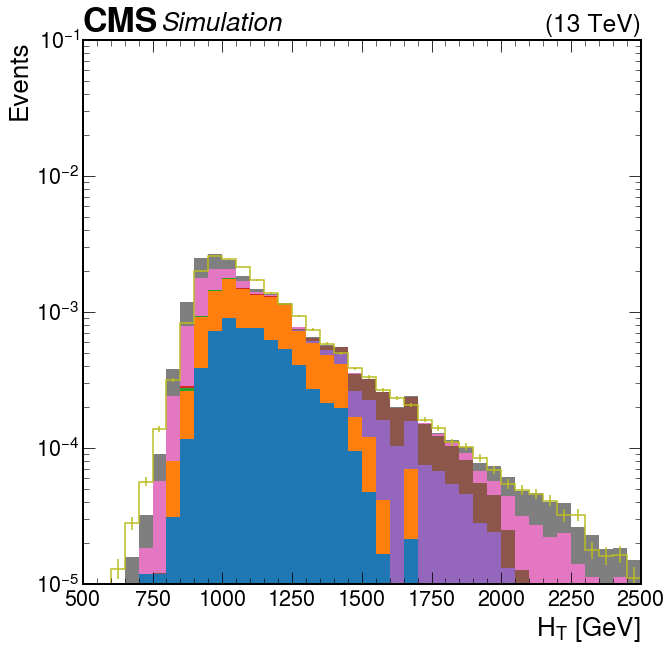

In [32]:
fig = plt.figure()
ax = fig.subplots()

#hep.cms.label(data=False, year='2018')
hep.style.use("ROOT")
# {"ALICE" | "ATLAS" | "CMS" | "LHCb1" | "LHCb2"}
hep.cms.label(data=False)

_ = ax.set_yscale('log')
coffea.hist.plot.plot1d(output['ht_reco_triggered']['QCDHT*'], ax=ax, clear=False, stack=True, density=True)
coffea.hist.plot.plot1d(output_mu['ht_reco_triggered']["Data"], ax=ax, clear=False, stack=False, density=True)
_ = ax.set_xlim(500, 2500)
_ = ax.set_ylim(1e-5, 1e-1)
ax.get_legend().remove()

plt.savefig(outDir + 'ht_reco_triggered_{}.pdf'.format(year))

In [33]:
val_trig = 0
val = 0
var_trig = 0
var = 0
i = 0
for sample in output['ht_reco_triggered'].project('dataset').values():
    if 'QCDHT' not in sample[0]: continue
    bh_trig = output['ht_reco_triggered'][sample[0]].to_boost()
    bh = output['ht_reco'][sample[0]].to_boost() 
    if i == 0:
        bins_use = bh_trig.axes.edges[1][0]
        val_trig = bh_trig.values()[0]
        val= bh.values()[0]
        var_trig = bh_trig.variances()[0]
        var= bh.variances()[0]
    else:
        val_trig += bh_trig.values()[0]
        val += bh.values()[0]
        var_trig += bh_trig.variances()[0]
        var += bh.variances()[0]
    i += 1

#val_trig = np.array([ x+y for x,y in zip(val_trig[0::2], val_trig[1::2]) ])
#val = np.array([ x+y for x,y in zip(val[0::2], val[1::2]) ])
#var_trig = np.array([ x+y for x,y in zip(var_trig[0::2], var_trig[1::2]) ])
#var = np.array([ x+y for x,y in zip(var[0::2], var[1::2]) ])
x = val_trig/val
x2 = np.nan_to_num(x)*100

In [34]:
val_trig_data = 0
val_data = 0
var_trig_data = 0
var_data = 0
i = 0
for sample in output_mu['ht_reco_triggered'].project('dataset').values():
    if 'data' not in sample[0].lower(): continue
    bh_trig_data = output_mu['ht_reco_triggered'][sample[0]].to_boost()
    bh_data = output_mu['ht_reco'][sample[0]].to_boost()
    if i == 0:
        val_trig_data = bh_trig_data.values()[0]
        val_data= bh_data.values()[0]
        var_trig_data = bh_trig_data.variances()[0]
        var_data= bh_data.variances()[0]
    else:
        val_trig_data += bh_trig_data.values()[0]
        val_data += bh_data.values()[0]
        var_trig_data+= bh_trig_data.variances()[0]
        var_data += bh_data.variances()[0]
    i += 1
    
    
#val_trig_data = np.array([ x+y for x,y in zip(val_trig_data[0::2], val_trig_data[1::2]) ])
#val_data = np.array([ x+y for x,y in zip(val_data[0::2], val_data[1::2]) ])
#var_trig_data = np.array([ x+y for x,y in zip(var_trig_data[0::2], var_trig_data[1::2]) ])
#var_data = np.array([ x+y for x,y in zip(var_data[0::2], var_data[1::2]) ])
x_data = val_trig_data/val_data
x_data2 = np.nan_to_num(x_data)*100

In [35]:
#bins_use=bins_use[0::2]
import hist
from hist import intervals
MC_err = hist.intervals.ratio_uncertainty(num=val_trig,denom=val,uncertainty_type='efficiency')
data_err = hist.intervals.ratio_uncertainty(num=val_trig_data,denom=val_data,uncertainty_type='efficiency')

In [36]:
binc = np.array([ 0.5*(bins_use[i]+bins_use[i+1])for i in range(bins_use.shape[0]-1)])
xerr = np.diff(bins_use)*0.5

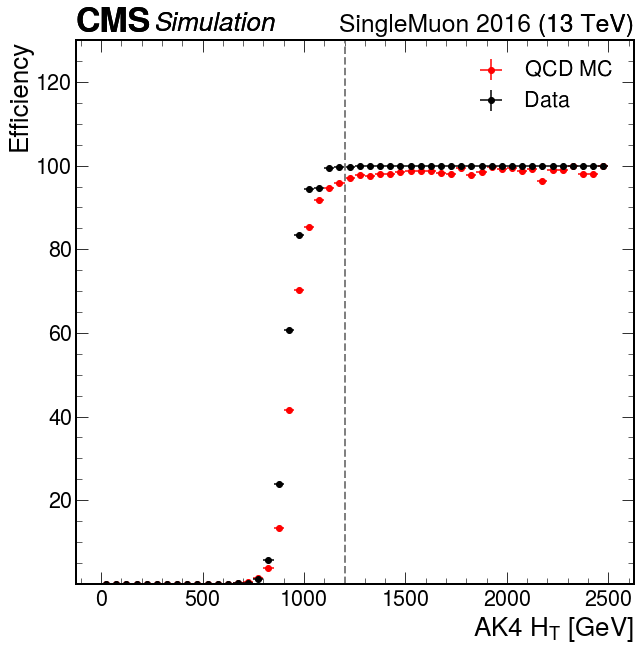

In [37]:
fig = plt.figure()
ax = fig.subplots()

hep.cms.label(data=False, year='SingleMuon '+str(year))
hep.style.use("ROOT")
# {"ALICE" | "ATLAS" | "CMS" | "LHCb1" | "LHCb2"}
hep.cms.label(data=False)
binc = np.array([ 0.5*(bins_use[i]+bins_use[i+1])for i in range(bins_use.shape[0]-1)])
plt.errorbar(binc,x_data2, xerr=xerr,yerr=[data_err[0],data_err[1]],color="red", fmt='o')
plt.errorbar(binc,x2, xerr=xerr,yerr=[MC_err[0],MC_err[1]],color="black", fmt='o')
#plt.axvline(x=1200, color='gray',ls='--', lw=2)
_ = ax.set_ylim(0.001, 130)
_ = ax.set_ylabel("Efficiency")
_ = ax.set_xlabel(r"AK4 $H_{T}$ [GeV]")
plt.rcParams['text.usetex'] = True
labels = [r"QCD MC",r"Data"]
leg = ax.legend(labels=labels)
plt.axvline(x=1200, color='gray',ls='--', lw=2)

plt.savefig(outDir + 'eff_{}.pdf'.format(year))

In [38]:
z=np.nan_to_num(x_data2/x2)
z=np.clip(z,0,15)
z_up = np.nan_to_num((x_data2+data_err[0])/(x2-MC_err[1])) - z
z_up = np.clip(z_up,0,15)
z_down = z - np.nan_to_num((x_data2-data_err[1])/(x2+MC_err[0]))
z_down = np.clip(z_down,0,15)

/tmp/ipykernel_3824624/1942878560.py:1: RuntimeWarning: divide by zero encountered in true_divide
  z=np.nan_to_num(x_data2/x2)
/tmp/ipykernel_3824624/1942878560.py:1: RuntimeWarning: invalid value encountered in true_divide
  z=np.nan_to_num(x_data2/x2)
/tmp/ipykernel_3824624/1942878560.py:5: RuntimeWarning: divide by zero encountered in true_divide
  z_down = z - np.nan_to_num((x_data2-data_err[1])/(x2+MC_err[0]))


In [39]:
#z=np.clip(z,0,1.5)
#z_up=np.clip(z_up,0,1.5)
#_down=np.clip(z_down,0,1.5)

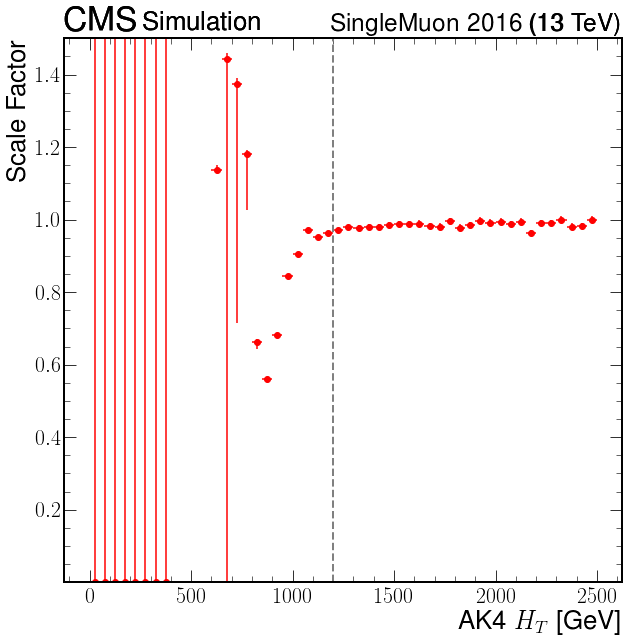

In [40]:
fig = plt.figure()
ax = fig.subplots()

hep.cms.label(data=False, year='SingleMuon '+str(year))
hep.style.use("ROOT")
# {"ALICE" | "ATLAS" | "CMS" | "LHCb1" | "LHCb2"}
hep.cms.label(data=False)
plt.errorbar(binc,z, xerr=xerr,yerr=[z_up,z_down],color="red", fmt='o')
_ = ax.set_ylim(0.001, 1.5)
_ = ax.set_ylabel("Scale Factor")
_ = ax.set_xlabel(r"AK4 $H_{T}$ [GeV]")
plt.axvline(x=1200, color='gray',ls='--', lw=2)

plt.savefig(outDir + 'trigSF_{}.pdf'.format(year))

In [41]:
import uproot
outfile = uproot.recreate(outDir+"trigSF_{}.root".format(year))

In [42]:
z_var = np.maximum(z_up,z_down)

In [43]:
z_var

array([1.50000000e+01, 1.50000000e+01, 1.50000000e+01, 1.50000000e+01,
       1.50000000e+01, 1.50000000e+01, 1.50000000e+01, 1.50000000e+01,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 3.02601505e-02,
       1.33013730e-02, 2.83684425e+00, 6.60732683e-01, 1.53535149e-01,
       1.99733824e-02, 5.53714764e-03, 2.88024612e-03, 3.11405635e-03,
       3.38847380e-03, 4.35936698e-03, 4.93450225e-03, 5.22216349e-03,
       5.83220354e-03, 7.31303772e-03, 7.82895858e-03, 8.25160791e-03,
       8.31565179e-03, 9.30415832e-03, 9.45990774e-03, 9.65637402e-03,
       9.77381211e-03, 9.65847853e-03, 9.76070745e-03, 9.88272094e-03,
       9.75426608e-03, 9.81511771e-03, 9.89460058e-03, 9.86923682e-03,
       9.89110785e-03, 9.85657079e-03, 9.88928173e-03, 9.69020374e-03,
       9.88423534e-03, 9.88439787e-03, 9.90099010e-03, 9.86815173e-03,
       9.86877031e-03, 9.90099010e-03])

In [44]:
import boost_histogram as bh
newhist = bh.Histogram(bh.axis.Variable(bins_use),storage=bh.storage.Weight())
newhist[:] = np.stack([z, z_var], axis=-1)

In [45]:
#outfile['efficiency_Data'] = x_data2
#outfile['efficiency_MC'] = x_2
outfile['TriggerSF'] = newhist
outfile.close()

In [13]:
import uproot
import mplhep as hep
import matplotlib.pyplot as plt

infile = uproot.open("/home/submit/lavezzo/SUEP/paper_version/SUEPCoffea_dask/data/trigSF/trigSF_2018.root")

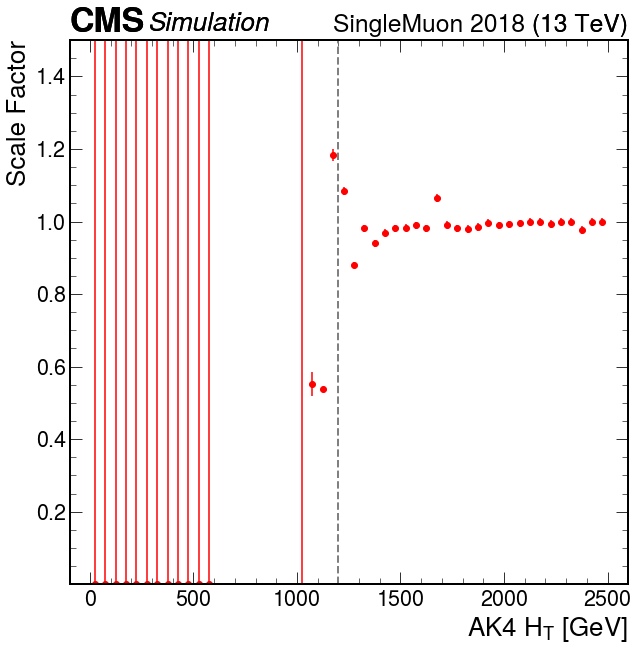

In [25]:
h = infile['TriggerSF'].to_hist()
binc = h.axes[0].centers
z = h.values()
z_up, z_down = h.variances(), h.variances()

fig = plt.figure()
ax = fig.subplots()

hep.cms.label(data=False, year='SingleMuon 2018')
hep.style.use("ROOT")
# {"ALICE" | "ATLAS" | "CMS" | "LHCb1" | "LHCb2"}
hep.cms.label(data=False)
plt.errorbar(binc,z,yerr=[z_up,z_down],color="red", fmt='o')
_ = ax.set_ylim(0.001, 1.5)
_ = ax.set_ylabel("Scale Factor")
_ = ax.set_xlabel(r"AK4 $H_{T}$ [GeV]")
plt.axvline(x=1200, color='gray',ls='--', lw=2)

plt.savefig(outDir + 'trigSF_{}.pdf'.format(2018))